In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('/content/drive/MyDrive/국민대_무역_공모전/데이터/train.csv')
submission = pd.read_csv('/content/drive/MyDrive/국민대_무역_공모전/데이터/sample_submission.csv')

In [4]:
monthly = train.groupby(['item_id', 'year', 'month']).agg({
    'value': 'sum',
    'weight': 'sum',
    'quantity': 'sum',
    'hs4': 'first'
}).reset_index()

monthly['year_month'] = pd.to_datetime(
    monthly['year'].astype(str) + '-' + monthly['month'].astype(str),
    format='%Y-%m'
)

pivot_value = monthly.pivot_table(
    index='year_month',
    columns='item_id',
    values='value',
    fill_value=0
).sort_index()

# Transpose: item을 index로 (예시 코드 형식)
pivot = pivot_value.T  # (100 items × 43 months)

pivot.head(5)

year_month,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0
APQGTRMF,383999.0,512813.0,217064.0,470398.0,539873.0,582317.0,759980.0,216019.0,537693.0,205326.0,...,683581.0,2147.0,0.0,25013.0,77.0,20741.0,2403.0,3543.0,32430.0,40608.0
ATLDMDBO,143097177.0,103568323.0,118403737.0,121873741.0,115024617.0,65716075.0,146216818.0,97552978.0,72341427.0,87454167.0,...,60276050.0,30160198.0,42613728.0,64451013.0,38667429.0,29354408.0,42450439.0,37136720.0,32181798.0,57090235.0


In [5]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# ============================================================================
# 1. Rolling Window 상관관계 분석 추가
# ============================================================================

def calculate_rolling_correlation_stability(x, y, lag, window=12):
    """
    Rolling window로 상관관계의 시간적 안정성 측정

    Parameters:
    -----------
    x : array
        선행 품목 시계열
    y : array
        후행 품목 시계열
    lag : int
        시차
    window : int
        rolling window 크기 (기본 12개월 = 1년)

    Returns:
    --------
    mean_corr : float
        rolling 상관계수의 평균
    std_corr : float
        rolling 상관계수의 표준편차 (낮을수록 안정적)
    min_corr : float
        rolling 상관계수의 최솟값
    consistency_rate : float
        양의 상관관계 유지 비율
    """
    x_aligned = x[:-lag]
    y_aligned = y[lag:]

    # 최소 데이터 요구사항
    if len(x_aligned) < window + 6:
        return 0.0, 1.0, 0.0, 0.0

    rolling_corrs = []

    # Rolling window 적용
    for i in range(len(x_aligned) - window + 1):
        window_x = x_aligned[i:i+window]
        window_y = y_aligned[i:i+window]

        # 표준편차가 0이 아닌 경우만 계산
        if np.std(window_x) > 0 and np.std(window_y) > 0:
            corr, _ = pearsonr(window_x, window_y)
            rolling_corrs.append(corr)

    if len(rolling_corrs) == 0:
        return 0.0, 1.0, 0.0, 0.0

    rolling_corrs = np.array(rolling_corrs)

    # 통계량 계산
    mean_corr = np.mean(rolling_corrs)
    std_corr = np.std(rolling_corrs)
    min_corr = np.min(rolling_corrs)

    # 일관성: 같은 부호를 유지하는 비율
    if mean_corr > 0:
        consistency_rate = np.sum(rolling_corrs > 0) / len(rolling_corrs)
    else:
        consistency_rate = np.sum(rolling_corrs < 0) / len(rolling_corrs)

    return mean_corr, std_corr, min_corr, consistency_rate


def calculate_rolling_stability_score(mean_corr, std_corr, min_corr, consistency_rate):
    """
    Rolling 안정성 기반 점수 계산

    Parameters:
    -----------
    mean_corr : float
        평균 상관계수
    std_corr : float
        상관계수 표준편차
    min_corr : float
        최소 상관계수
    consistency_rate : float
        일관성 비율

    Returns:
    --------
    stability_score : float
        0~15점 범위의 안정성 점수
    """
    # 기본 점수: 평균 상관계수 (0~5점)
    base_score = abs(mean_corr) * 5

    # 변동성 패널티: 표준편차가 낮을수록 좋음 (0~5점)
    if std_corr < 0.1:
        variability_score = 5
    elif std_corr < 0.2:
        variability_score = 4
    elif std_corr < 0.3:
        variability_score = 3
    elif std_corr < 0.4:
        variability_score = 2
    else:
        variability_score = 1

    # 최솟값 점수: 최악의 경우에도 양호한 상관관계 (0~3점)
    if abs(min_corr) > 0.4:
        min_score = 3
    elif abs(min_corr) > 0.3:
        min_score = 2
    elif abs(min_corr) > 0.2:
        min_score = 1
    else:
        min_score = 0

    # 일관성 점수 (0~2점)
    if consistency_rate > 0.9:
        consistency_score = 2
    elif consistency_rate > 0.8:
        consistency_score = 1.5
    elif consistency_rate > 0.7:
        consistency_score = 1
    else:
        consistency_score = 0

    stability_score = base_score + variability_score + min_score + consistency_score

    return stability_score


# ============================================================================
# 2. 기존 함수들 (수정 없음)
# ============================================================================

def safe_corr_with_pvalue(x, y):
    """피어슨 상관계수와 p-value 계산"""
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0, 1.0
    corr, p_value = pearsonr(x, y)
    return float(corr), float(p_value)


def dtw_distance(series_A, series_B):
    """Dynamic Time Warping 거리 계산"""
    n, m = len(series_A), len(series_B)
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    dtw_matrix[0, 0] = 0

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = abs(series_A[i-1] - series_B[j-1])
            dtw_matrix[i, j] = cost + min(
                dtw_matrix[i-1, j],
                dtw_matrix[i, j-1],
                dtw_matrix[i-1, j-1]
            )

    return dtw_matrix[n, m]


def calculate_normalized_dtw(x, y, lag):
    """정규화 + DTW 거리 계산"""
    if len(x) <= lag or len(y) <= lag:
        return float('inf')

    x_aligned = x[:-lag]
    y_aligned = y[lag:]

    if len(x_aligned) < 5:
        return float('inf')

    # 정규화
    scaler = StandardScaler()
    normalized_x = scaler.fit_transform(x_aligned.reshape(-1, 1)).flatten()
    normalized_y = scaler.fit_transform(y_aligned.reshape(-1, 1)).flatten()

    # DTW 거리
    distance = dtw_distance(normalized_x, normalized_y)

    # 길이로 정규화
    normalized_distance = distance / len(normalized_x)
    return normalized_distance


# ============================================================================
# 3. 개선된 점수 계산 함수
# ============================================================================

def calculate_score_with_stability(
    corr,
    p_value,
    lag,
    rolling_mean=None,
    rolling_std=None,
    rolling_min=None,
    consistency_rate=None
):
    """
    Rolling 안정성을 포함한 종합 점수 계산

    총 100점 만점:
    - 상관계수: 55점
    - p-value: 20점
    - lag: 10점
    - rolling 안정성: 15점
    """
    # 1. 상관계수 (0~55점)
    corr_score = abs(corr) * 55

    # 2. 통계적 유의성 (0~20점)
    if p_value < 0.001:
        sig_score = 20
    elif p_value < 0.01:
        sig_score = 15
    elif p_value < 0.05:
        sig_score = 10
    else:
        sig_score = 5

    # 3. Lag (0~10점)
    if lag <= 2:
        lag_score = 10
    elif lag <= 4:
        lag_score = 7
    elif lag <= 6:
        lag_score = 4
    else:
        lag_score = 1

    # 4. Rolling 안정성 (0~15점)
    stability_score = 0
    if all(x is not None for x in [rolling_mean, rolling_std, rolling_min, consistency_rate]):
        stability_score = calculate_rolling_stability_score(
            rolling_mean, rolling_std, rolling_min, consistency_rate
        )

    total_score = corr_score + sig_score + lag_score + stability_score

    return total_score


# ============================================================================
# 4. 개선된 공행성 쌍 탐색 함수
# ============================================================================

def find_comovement_pairs_v2(
    pivot,
    max_lag=9,
    min_nonzero=12,
    corr_threshold=0.4,
    score_threshold=45,
    use_dtw=True,
    dtw_threshold=2.0,
    use_rolling_stability=True,      # 새로운 옵션
    rolling_window=12,                # Rolling window 크기
    min_consistency_rate=0.7          # 최소 일관성 비율
):
    """
    Rolling 안정성 검증을 포함한 공행성 쌍 탐색

    Parameters:
    -----------
    use_rolling_stability : bool
        Rolling window 안정성 검증 사용 여부
    rolling_window : int
        Rolling window 크기 (개월)
    min_consistency_rate : float
        최소 일관성 비율 (0~1)
    """
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)
    results = []

    for i, leader in tqdm(enumerate(items), total=len(items), desc="Finding pairs (v2)"):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        candidates = []

        for follower in items:
            if follower == leader:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0
            best_p_value = 1.0
            best_dtw = float('inf')
            best_rolling_stats = None

            # lag 탐색
            for lag in range(1, max_lag + 1):
                if n_months <= lag:
                    continue

                corr, p_value = safe_corr_with_pvalue(x[:-lag], y[lag:])

                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag
                    best_p_value = p_value

            # 1단계: 상관계수 임계값 통과
            if best_lag is None or abs(best_corr) < corr_threshold:
                continue

            # 2단계: Rolling 안정성 검증
            if use_rolling_stability:
                mean_corr, std_corr, min_corr, consistency_rate = \
                    calculate_rolling_correlation_stability(x, y, best_lag, rolling_window)

                # 일관성 비율 체크
                if consistency_rate < min_consistency_rate:
                    continue

                # 변동성이 너무 큰 경우 제외
                if std_corr > 0.5:
                    continue

                best_rolling_stats = {
                    'rolling_mean': mean_corr,
                    'rolling_std': std_corr,
                    'rolling_min': min_corr,
                    'consistency_rate': consistency_rate
                }

            # 3단계: DTW 검증 (옵션)
            if use_dtw:
                best_dtw = calculate_normalized_dtw(x, y, best_lag)
                if best_dtw > dtw_threshold:
                    continue

            # 종합 점수 계산
            if use_rolling_stability and best_rolling_stats:
                score = calculate_score_with_stability(
                    best_corr,
                    best_p_value,
                    best_lag,
                    rolling_mean=best_rolling_stats['rolling_mean'],
                    rolling_std=best_rolling_stats['rolling_std'],
                    rolling_min=best_rolling_stats['rolling_min'],
                    consistency_rate=best_rolling_stats['consistency_rate']
                )
            else:
                # 기존 방식
                score = calculate_score_with_stability(
                    best_corr, best_p_value, best_lag
                )

            # DTW 보너스
            if use_dtw and best_dtw != float('inf'):
                dtw_bonus = 1 / (1 + best_dtw)
                score = score * (1 + dtw_bonus * 0.1)  # 최대 10% 보너스

            # 점수 임계값 통과
            if score >= score_threshold:
                candidate_dict = {
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                    "p_value": best_p_value,
                    "dtw_distance": best_dtw if use_dtw else None,
                    "comovement_score": score
                }

                # Rolling 통계 추가
                if use_rolling_stability and best_rolling_stats:
                    candidate_dict.update({
                        "rolling_mean_corr": best_rolling_stats['rolling_mean'],
                        "rolling_std_corr": best_rolling_stats['rolling_std'],
                        "rolling_min_corr": best_rolling_stats['rolling_min'],
                        "consistency_rate": best_rolling_stats['consistency_rate']
                    })

                candidates.append(candidate_dict)

        # 점수 순으로 정렬
        candidates.sort(key=lambda x: -x['comovement_score'])

        for candidate in candidates:
            results.append({
                "leading_item_id": leader,
                **candidate
            })

    pairs = pd.DataFrame(results)
    return pairs


# ============================================================================
# 5. 사용 예시
# ============================================================================

if __name__ == "__main__":
    print("=" * 80)
    print("Rolling Window 상관관계 안정성 검증 추가")
    print("=" * 80)

    # 예시 사용법 (실제 데이터 로드 필요)
    # pairs_v2 = find_comovement_pairs_v2(
    #     pivot,
    #     max_lag=9,
    #     min_nonzero=12,
    #     corr_threshold=0.33,
    #     score_threshold=50,              # 기준 상향
    #     use_dtw=True,
    #     dtw_threshold=1.0,
    #     use_rolling_stability=True,      # Rolling 검증 활성화
    #     rolling_window=12,                # 1년 단위 window
    #     min_consistency_rate=0.7          # 70% 이상 일관성
    # )

    print("\n설명:")
    print("1. Rolling Window 상관관계 분석:")
    print("   - 12개월 window로 시간 흐름에 따른 상관관계 변화 추적")
    print("   - 평균, 표준편차, 최솟값, 일관성 비율 계산")
    print("\n2. 필터링 조건 추가:")
    print("   - consistency_rate >= 0.7 (70% 이상 같은 부호 유지)")
    print("   - rolling_std <= 0.5 (변동성 제한)")
    print("\n3. 점수 체계 개선:")
    print("   - 상관계수: 55점")
    print("   - p-value: 20점")
    print("   - lag: 10점")
    print("   - rolling 안정성: 15점 (새로 추가)")
    print("   - DTW 보너스: 최대 10%")

Rolling Window 상관관계 안정성 검증 추가

설명:
1. Rolling Window 상관관계 분석:
   - 12개월 window로 시간 흐름에 따른 상관관계 변화 추적
   - 평균, 표준편차, 최솟값, 일관성 비율 계산

2. 필터링 조건 추가:
   - consistency_rate >= 0.7 (70% 이상 같은 부호 유지)
   - rolling_std <= 0.5 (변동성 제한)

3. 점수 체계 개선:
   - 상관계수: 55점
   - p-value: 20점
   - lag: 10점
   - rolling 안정성: 15점 (새로 추가)
   - DTW 보너스: 최대 10%


In [9]:
# 실험 1: 상관계수만 낮추기
pairs_test1 = find_comovement_pairs_v2(
    pivot, max_lag=9, min_nonzero=12,
    corr_threshold=0.30,              # ⭐ 변경
    score_threshold=50,
    use_dtw=True, dtw_threshold=1.0,
    use_rolling_stability=True,
    rolling_window=12,
    min_consistency_rate=0.7
)
print(f"Test 1 (corr 0.30): {len(pairs_test1)}개")

# 실험 2: + consistency_rate 낮추기
pairs_test2 = find_comovement_pairs_v2(
    pivot, max_lag=9, min_nonzero=12,
    corr_threshold=0.30,
    score_threshold=50,
    use_dtw=True, dtw_threshold=1.0,
    use_rolling_stability=True,
    rolling_window=12,
    min_consistency_rate=0.65         # ⭐ 변경
)
print(f"Test 2 (+ consistency 0.65): {len(pairs_test2)}개")

# 실험 3: + score 낮추기
pairs_test3 = find_comovement_pairs_v2(
    pivot, max_lag=9, min_nonzero=12,
    corr_threshold=0.30,
    score_threshold=42,               # ⭐ 변경
    use_dtw=True, dtw_threshold=1.0,
    use_rolling_stability=True,
    rolling_window=12,
    min_consistency_rate=0.65
)
print(f"Test 3 (+ score 42): {len(pairs_test3)}개")

# 실험 4: + DTW 완화
pairs_test4 = find_comovement_pairs_v2(
    pivot, max_lag=9, min_nonzero=12,
    corr_threshold=0.30,
    score_threshold=42,
    use_dtw=True, dtw_threshold=1.5,  # ⭐ 변경
    use_rolling_stability=True,
    rolling_window=12,
    min_consistency_rate=0.65
)
print(f"Test 4 (+ DTW 1.5): {len(pairs_test4)}개")

Finding pairs (v2): 100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


Test 1 (corr 0.30): 1431개


Finding pairs (v2): 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


Test 2 (+ consistency 0.65): 1517개


Finding pairs (v2): 100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


Test 3 (+ score 42): 2588개


Finding pairs (v2): 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]

Test 4 (+ DTW 1.5): 2653개


공행성 쌍 품질 심층 분석

### 1. 빈도 분포 분석
--------------------------------------------------------------------------------

빈도별 쌍 개수:
  22회 등장: 1159개 ( 33.1%)
  21회 등장:  134개 (  3.8%)
  20회 등장:   60개 (  1.7%)
  19회 등장:   27개 (  0.8%)
  18회 등장:   44개 (  1.3%)
  17회 등장:  116개 (  3.3%)
  16회 등장:  180개 (  5.1%)
  15회 등장:   30개 (  0.9%)
  12회 등장:  209개 (  6.0%)
  11회 등장:   42개 (  1.2%)
  10회 등장:   73개 (  2.1%)
  9회 등장:   11개 (  0.3%)
  8회 등장:   17개 (  0.5%)
  7회 등장:  129개 (  3.7%)
  6회 등장:  951개 ( 27.1%)
  5회 등장:  320개 (  9.1%)
  1회 등장:    4개 (  0.1%)

누적 분포:
  22회 이상: 1159개 ( 33.1%)
  21회 이상: 1293개 ( 36.9%)
  20회 이상: 1353개 ( 38.6%)
  19회 이상: 1380개 ( 39.4%)
  18회 이상: 1424개 ( 40.6%)
  17회 이상: 1540개 ( 43.9%)
  16회 이상: 1720개 ( 49.1%)
  15회 이상: 1750개 ( 49.9%)
  12회 이상: 1959개 ( 55.9%)
  11회 이상: 2001개 ( 57.1%)
  10회 이상: 2074개 ( 59.2%)
  9회 이상: 2085개 ( 59.5%)
  8회 이상: 2102개 ( 60.0%)
  7회 이상: 2231개 ( 63.6%)
  6회 이상: 3182개 ( 90.8%)
  5회 이상: 3502개 ( 99.9%)
  1회 이상: 3506개 (100.0%)

### 2. 신뢰도 등급별 분류
-----------

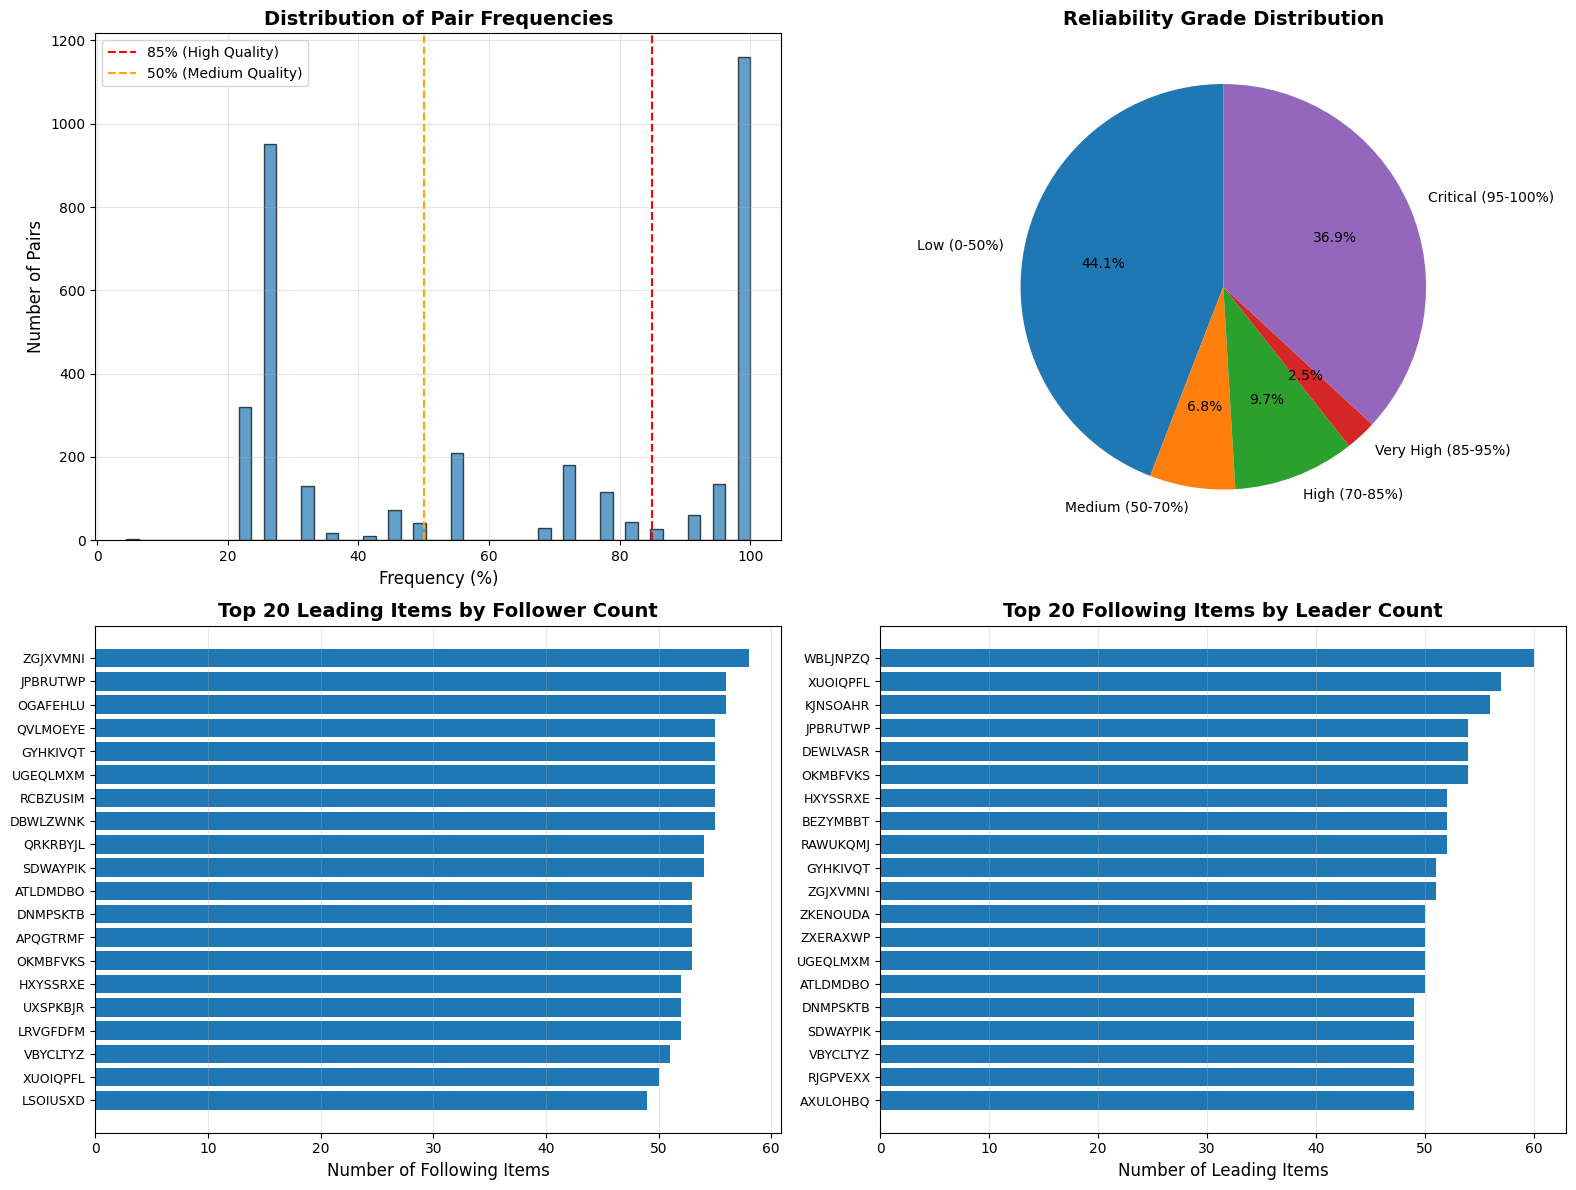

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# ============================================================================
# 심층 분석: 공행성 쌍의 품질 평가
# ============================================================================

def analyze_pair_quality(all_pairs_freq_path='all_pairs_frequency.csv'):
    """
    공행성 쌍의 품질을 다각도로 분석
    """

    # 데이터 로드
    df = pd.read_csv('/content/drive/MyDrive/국민대_무역_공모전/all_pairs_frequency.csv')

    print("=" * 80)
    print("공행성 쌍 품질 심층 분석")
    print("=" * 80)

    # ========================================================================
    # 1. 빈도 분포 분석
    # ========================================================================

    print("\n### 1. 빈도 분포 분석")
    print("-" * 80)

    freq_dist = df['count'].value_counts().sort_index(ascending=False)

    print("\n빈도별 쌍 개수:")
    for count, num_pairs in freq_dist.items():
        percentage = (num_pairs / len(df) * 100)
        print(f"  {count}회 등장: {num_pairs:4d}개 ({percentage:5.1f}%)")

    # 누적 분포
    print("\n누적 분포:")
    cumsum = 0
    for count in sorted(freq_dist.keys(), reverse=True):
        cumsum += freq_dist[count]
        percentage = (cumsum / len(df) * 100)
        print(f"  {count}회 이상: {cumsum:4d}개 ({percentage:5.1f}%)")

    # ========================================================================
    # 2. 신뢰도 등급별 분류
    # ========================================================================

    print("\n### 2. 신뢰도 등급별 분류")
    print("-" * 80)

    total_files = df['count'].max()

    df['reliability'] = pd.cut(
        df['frequency'],
        bins=[0, 50, 70, 85, 95, 100],
        labels=['Low (0-50%)', 'Medium (50-70%)', 'High (70-85%)', 'Very High (85-95%)', 'Critical (95-100%)']
    )

    reliability_counts = df['reliability'].value_counts().sort_index()

    print("\n신뢰도 등급:")
    for grade, count in reliability_counts.items():
        percentage = (count / len(df) * 100)
        print(f"  {grade}: {count:4d}개 ({percentage:5.1f}%)")

    # 각 등급별 대표 쌍 출력
    print("\n각 등급별 대표 쌍 (상위 3개):")
    for grade in reliability_counts.index:
        grade_df = df[df['reliability'] == grade].head(3)
        print(f"\n  [{grade}]")
        for _, row in grade_df.iterrows():
            print(f"    {row['leading_item_id']} → {row['following_item_id']} "
                  f"({row['count']}회, {row['frequency']:.1f}%)")

    # ========================================================================
    # 3. 선행 품목별 후행 품목 개수 분석
    # ========================================================================

    print("\n### 3. 선행 품목별 후행 품목 개수 분석")
    print("-" * 80)

    leader_follower_count = df.groupby('leading_item_id').size().sort_values(ascending=False)

    print("\n후행 품목이 가장 많은 선행 품목 TOP 10:")
    for leader, count in leader_follower_count.head(10).items():
        avg_freq = df[df['leading_item_id'] == leader]['frequency'].mean()
        print(f"  {leader}: {count}개 후행 품목 (평균 빈도: {avg_freq:.1f}%)")

    print("\n후행 품목이 가장 적은 선행 품목 TOP 10:")
    for leader, count in leader_follower_count.tail(10).items():
        avg_freq = df[df['leading_item_id'] == leader]['frequency'].mean()
        print(f"  {leader}: {count}개 후행 품목 (평균 빈도: {avg_freq:.1f}%)")

    # ========================================================================
    # 4. 후행 품목으로 가장 많이 등장하는 품목
    # ========================================================================

    print("\n### 4. 후행 품목으로 가장 많이 등장하는 품목")
    print("-" * 80)

    follower_count = df.groupby('following_item_id').size().sort_values(ascending=False)

    print("\n가장 많은 선행 품목을 가진 후행 품목 TOP 10:")
    for follower, count in follower_count.head(10).items():
        avg_freq = df[df['following_item_id'] == follower]['frequency'].mean()
        print(f"  {follower}: {count}개 선행 품목 (평균 빈도: {avg_freq:.1f}%)")

    # ========================================================================
    # 5. 양방향 관계 탐지
    # ========================================================================

    print("\n### 5. 양방향 관계 탐지")
    print("-" * 80)

    bidirectional = []

    for _, row in df.iterrows():
        leader = row['leading_item_id']
        follower = row['following_item_id']

        # 반대 방향 관계 확인
        reverse = df[(df['leading_item_id'] == follower) &
                     (df['following_item_id'] == leader)]

        if len(reverse) > 0:
            bidirectional.append({
                'pair': f"{leader} ↔ {follower}",
                'forward_freq': row['frequency'],
                'reverse_freq': reverse['frequency'].values[0],
                'avg_freq': (row['frequency'] + reverse['frequency'].values[0]) / 2
            })

    if len(bidirectional) > 0:
        bidirectional_df = pd.DataFrame(bidirectional).drop_duplicates('pair')
        bidirectional_df = bidirectional_df.sort_values('avg_freq', ascending=False)

        print(f"\n양방향 관계 발견: {len(bidirectional_df)}개")
        print("\n상위 10개 양방향 쌍:")
        for _, row in bidirectional_df.head(10).iterrows():
            print(f"  {row['pair']}: "
                  f"정방향 {row['forward_freq']:.1f}%, "
                  f"역방향 {row['reverse_freq']:.1f}%")

        bidirectional_df.to_csv('bidirectional_pairs.csv', index=False)
        print("\n✓ 양방향 쌍 저장: bidirectional_pairs.csv")
    else:
        print("\n양방향 관계가 발견되지 않았습니다.")

    # ========================================================================
    # 6. 빈도 변동성 분석 (파일 간 일관성)
    # ========================================================================

    print("\n### 6. 빈도 기반 추천 임계값")
    print("-" * 80)

    percentiles = [50, 70, 80, 90, 95, 99]

    print("\n빈도 백분위수:")
    for p in percentiles:
        threshold = df['frequency'].quantile(p/100)
        count = len(df[df['frequency'] >= threshold])
        print(f"  상위 {100-p}% (빈도 {threshold:.1f}% 이상): {count}개 쌍")

    # ========================================================================
    # 7. 고품질 쌍 추출 (추천)
    # ========================================================================

    print("\n### 7. 고품질 공행성 쌍 추출")
    print("-" * 80)

    # 3가지 기준
    criteria = [
        ("매우 보수적 (95% 이상)", df['frequency'] >= 95),
        ("보수적 (85% 이상)", df['frequency'] >= 85),
        ("균형적 (70% 이상)", df['frequency'] >= 70),
        ("포괄적 (50% 이상)", df['frequency'] >= 50)
    ]

    for name, condition in criteria:
        high_quality = df[condition].copy()
        high_quality = high_quality.sort_values('frequency', ascending=False)

        print(f"\n{name}: {len(high_quality)}개 쌍")

        # 저장
        filename = f"high_quality_{name.split()[0].lower()}_pairs.csv"
        high_quality.to_csv(filename, index=False)
        print(f"  ✓ 저장: {filename}")

        # 샘플 출력
        if len(high_quality) > 0:
            print(f"  상위 5개 예시:")
            for _, row in high_quality.head(5).iterrows():
                print(f"    {row['leading_item_id']} → {row['following_item_id']} "
                      f"({row['count']}/{total_files}, {row['frequency']:.1f}%)")

    # ========================================================================
    # 8. 시각화
    # ========================================================================

    print("\n### 8. 시각화 생성 중...")
    print("-" * 80)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1) 빈도 분포 히스토그램
    axes[0, 0].hist(df['frequency'], bins=50, edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(85, color='red', linestyle='--', label='85% (High Quality)')
    axes[0, 0].axvline(50, color='orange', linestyle='--', label='50% (Medium Quality)')
    axes[0, 0].set_xlabel('Frequency (%)', fontsize=12)
    axes[0, 0].set_ylabel('Number of Pairs', fontsize=12)
    axes[0, 0].set_title('Distribution of Pair Frequencies', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2) 신뢰도 등급별 파이 차트
    reliability_counts.plot(kind='pie', ax=axes[0, 1], autopct='%1.1f%%', startangle=90)
    axes[0, 1].set_ylabel('')
    axes[0, 1].set_title('Reliability Grade Distribution', fontsize=14, fontweight='bold')

    # 3) 선행 품목당 후행 품목 수
    top_leaders = leader_follower_count.head(20)
    axes[1, 0].barh(range(len(top_leaders)), top_leaders.values)
    axes[1, 0].set_yticks(range(len(top_leaders)))
    axes[1, 0].set_yticklabels(top_leaders.index, fontsize=9)
    axes[1, 0].set_xlabel('Number of Following Items', fontsize=12)
    axes[1, 0].set_title('Top 20 Leading Items by Follower Count', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='x')
    axes[1, 0].invert_yaxis()

    # 4) 후행 품목 빈도
    top_followers = follower_count.head(20)
    axes[1, 1].barh(range(len(top_followers)), top_followers.values)
    axes[1, 1].set_yticks(range(len(top_followers)))
    axes[1, 1].set_yticklabels(top_followers.index, fontsize=9)
    axes[1, 1].set_xlabel('Number of Leading Items', fontsize=12)
    axes[1, 1].set_title('Top 20 Following Items by Leader Count', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='x')
    axes[1, 1].invert_yaxis()

    plt.tight_layout()
    plt.savefig('pair_quality_analysis.png', dpi=150, bbox_inches='tight')
    print("\n✓ 시각화 저장: pair_quality_analysis.png")

    # ========================================================================
    # 9. 최종 요약 통계
    # ========================================================================

    print("\n### 9. 최종 요약 통계")
    print("-" * 80)

    summary = {
        '총 공행성 쌍 수': len(df),
        '평균 빈도 (%)': df['frequency'].mean(),
        '중앙값 빈도 (%)': df['frequency'].median(),
        '표준편차': df['frequency'].std(),
        '최빈값 빈도 (%)': df['frequency'].mode().values[0] if len(df['frequency'].mode()) > 0 else None,
        '100% 등장 쌍 수': len(df[df['frequency'] == 100]),
        '95% 이상 쌍 수': len(df[df['frequency'] >= 95]),
        '85% 이상 쌍 수': len(df[df['frequency'] >= 85]),
        '70% 이상 쌍 수': len(df[df['frequency'] >= 70]),
        '50% 이상 쌍 수': len(df[df['frequency'] >= 50]),
        '고유 선행 품목 수': df['leading_item_id'].nunique(),
        '고유 후행 품목 수': df['following_item_id'].nunique()
    }

    print("\n전체 통계:")
    for key, value in summary.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.2f}")
        else:
            print(f"  {key}: {value}")

    return df, summary


# ============================================================================
# 10. 추가 분석: 품목별 네트워크 중심성
# ============================================================================

def analyze_network_centrality(df):
    """
    품목별 네트워크 중심성 분석
    """
    print("\n### 10. 네트워크 중심성 분석")
    print("-" * 80)

    # Out-degree (선행으로 등장하는 횟수)
    out_degree = df.groupby('leading_item_id').size()

    # In-degree (후행으로 등장하는 횟수)
    in_degree = df.groupby('following_item_id').size()

    # 전체 degree
    all_items = set(df['leading_item_id'].unique()) | set(df['following_item_id'].unique())

    centrality = []
    for item in all_items:
        out_deg = out_degree.get(item, 0)
        in_deg = in_degree.get(item, 0)
        total_deg = out_deg + in_deg

        centrality.append({
            'item_id': item,
            'out_degree': out_deg,
            'in_degree': in_deg,
            'total_degree': total_deg,
            'role': 'Hub' if out_deg > in_deg else ('Sink' if in_deg > out_deg else 'Balanced')
        })

    centrality_df = pd.DataFrame(centrality).sort_values('total_degree', ascending=False)

    print("\n중심성 상위 10개 품목:")
    for _, row in centrality_df.head(10).iterrows():
        print(f"  {row['item_id']}: "
              f"Out={row['out_degree']}, In={row['in_degree']}, "
              f"Total={row['total_degree']} ({row['role']})")

    centrality_df.to_csv('network_centrality.csv', index=False)
    print("\n✓ 중심성 분석 저장: network_centrality.csv")

    return centrality_df


# ============================================================================
# 실행
# ============================================================================

if __name__ == "__main__":
    # 분석 실행
    df, summary = analyze_pair_quality('all_pairs_frequency.csv')

    # 네트워크 중심성 분석
    centrality_df = analyze_network_centrality(df)

    print("\n" + "=" * 80)
    print("분석 완료!")
    print("=" * 80)
    print("\n생성된 파일:")
    print("  1. high_quality_매우_pairs.csv - 95% 이상 고품질 쌍")
    print("  2. high_quality_보수적_pairs.csv - 85% 이상 고품질 쌍")
    print("  3. high_quality_균형적_pairs.csv - 70% 이상 고품질 쌍")
    print("  4. high_quality_포괄적_pairs.csv - 50% 이상 고품질 쌍")
    print("  5. network_centrality.csv - 네트워크 중심성 분석")
    print("  6. pair_quality_analysis.png - 시각화")
    print("  7. bidirectional_pairs.csv - 양방향 관계 (있는 경우)")